In [73]:
! pip install scanpy

  Using cached scanpy-1.10.4-py3-none-any.whl.metadata (9.3 kB)
  Using cached anndata-0.11.1-py3-none-any.whl.metadata (8.2 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached session_info-1.0.0-py3-none-any.whl
  Using cached array_api_compat-1.9.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached stdlib_list-0.11.0-py3-none-any.whl.metadata (3.3 kB)
Using cached scanpy-1.10.4-py3-none-any.whl (2.1 MB)
Using cached anndata-0.11.1-py3-none-any.whl (141 kB)
Using cached natsort-8.4.0-py3-none-any.whl (38 kB)
Using cached array_api_compat-1.9.1-py3-none-any.whl (50 kB)
Using cached stdlib_list-0.11.0-py3-none-any.whl (83 kB)


In [1]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install pybiomart

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [164]:
import os
import re
import time
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import biomart
import requests

from Bio import Entrez
from biomart import BiomartServer
from pybiomart import Server
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Data Preprocessing:

## Loading, validating genn name and Log Transformation

In [99]:
response = pd.read_csv('/Users/hongleizhao/Documents/enlight-data-main/Data/drug_response_classifications.csv')
response

,Sample ID,Dataset,Response
0,PIK3CA-1113,MGH_Alpelisib,Responder
1,MGHCC1099,MGH_Ribociclib,Responder
2,MGHCC1573,MGH_Ribociclib,Non-responder
3,PIK3CA-0036,MGH_Alpelisib,Responder
4,PIK3CA-1039,MGH_Alpelisib,Responder
...,...,...,...
1002,Pt92_On,Anti-PD1,Non-responder
1003,Pt93_On,Anti-PD1,Non-responder
1004,Pt94_On,Anti-PD1,Responder
1005,Pt98_On,Anti-PD1,Non-responder


In [179]:

path = '/Users/hongleizhao/Documents/enlight-data-main/Data'
dataframes = {}
total_files = 0

def is_date_or_time(value):
    # Regex pattern to match common date or time-like formats (e.g., "1-Dec", "10_Mar", "12:30")
    date_time_pattern = r'(\d{1,2}[-/]\w{3}|\d{1,2}:\d{2}|\d{4}-\d{2}-\d{2})'
    return bool(re.match(date_time_pattern, str(value)))
    
# Function to check if a value is numeric or "---"
def is_invalid(value):
    return str(value).isdigit() or str(value).strip() == "---"
tcag_pattern = r'^[a-z]+\d+\.\d+$'
def is_tcag_pattern(value):
    return bool(re.match(tcag_pattern, str(value)))
    
# Load files and validate gene names
for file_name in os.listdir(path):
    if file_name.endswith('.csv') and file_name != 'drug_response_classifications.csv':  
        total_files += 1 
        file_path = os.path.join(path, file_name)  
        dataframe_name = file_name.replace('.csv', '')  # Remove .csv from file name
        df = pd.read_csv(file_path)
        
        # Rename the first column as 'index' if it is not already named 'index'
        if df.columns[0] != 'index':
            df.rename(columns={df.columns[0]: 'index'}, inplace=True)

        # Drop rows where the 'index' column contains only numeric values
        df = df[~df['index'].apply(is_invalid)]
        # Drop rows where the 'index' column contains date
        df = df[~df['index'].apply(is_date_or_time)]
        df = df[~df['index'].apply(is_tcag_pattern)]

        dataframes[dataframe_name] = df

for i, (file_name, df) in enumerate(dataframes.items(), start=1):
    globals()[f'df_{i}'] = df  # Create variable df_1, df_2, ..., df_n dynamically
    print(f"Loaded DataFrame {file_name} as df_{i}")

print(f"Total CSV files processed: {total_files}")

Loaded DataFrame Trastuzumab as df_1
Loaded DataFrame Cetuximab as df_2
Loaded DataFrame BRAFi_1 as df_3
Loaded DataFrame BRAFi_3 as df_4
Loaded DataFrame BRAFi_2 as df_5
Loaded DataFrame Lapatinib as df_6
Loaded DataFrame MGH_Alpelisib as df_7
Loaded DataFrame Rituximab as df_8
Loaded DataFrame Sorafenib_2 as df_9
Loaded DataFrame Trastuzumab_4 as df_10
Loaded DataFrame Trastuzumab_5 as df_11
Loaded DataFrame Tipifarnib_2 as df_12
Loaded DataFrame Selinexor as df_13
Loaded DataFrame Sorafenib as df_14
Loaded DataFrame Anti-PD1 +- Anti-CTLA4 as df_15
Loaded DataFrame Tipifarnib_1 as df_16
Loaded DataFrame Trastuzumab_2 as df_17
Loaded DataFrame Bevacizumab as df_18
Loaded DataFrame Trastuzumab_3 as df_19
Loaded DataFrame Bevacizumab_4 as df_20
Loaded DataFrame MGH_Ribociclib as df_21
Loaded DataFrame Anti-PD1_3 as df_22
Loaded DataFrame Anti-PD1_2 as df_23
Loaded DataFrame Vismodegib as df_24
Loaded DataFrame Bevacizumab_2 as df_25
Loaded DataFrame MK2206 as df_26
Loaded DataFrame Beva

In [180]:
# df_5, 24,30  raws name as date instead of genes
# df_1, 6,8, 10,16,17,18 names with ///
# df_20 nmaes with numbers  --drop
# df_2 gene or transcript ID
# df_11, 12, 13, 14, 16,21,23,25,29 log2
# df_7, 12,13 hsa-mir-423  columns_name  Unnamed: 0
# df_15 columns_name ID_REF	
# df_23 symbol 
# df_ 28 Unnamed: 0 to index, AL359091.2, AC137056.1 in index
# df_26 tcag7.981	


In [181]:
df_list = [df_11, df_12, df_13, df_14, df_16, df_21, df_23, df_25, df_29]

df_indices = [11, 12, 13, 14, 16, 21, 23, 25, 29]

# Loop through each DataFrame
for i in df_indices:
    # Access the DataFrame dynamically using globals()
    df_i = globals()[f'df_{i}'].copy()  # Replace with your actual DataFrame names
    
    # Apply log2 transformation and add the 'index' column back
    df_i_log = df_i.copy()
    df_i_log['index'] = df_i['index']
    df_i_log = np.log2(df_i_log.drop(columns=['index']) + 1)
    df_i_log.insert(0, 'index', df_i['index'])

In [220]:
pattern = r'^LOC\d+$'
loc_list = []

for i in range(1, 31):
    df_name = f"df_{i}"  # Create the DataFrame name dynamically
    if df_name in globals():  # Check if the DataFrame exists
        df = globals()[df_name]  # Access the DataFrame using globals()
        
        # Ensure 'index' exists in the DataFrame
        if 'index' in df.columns:
            # Check if the 'index' column contains LOC IDs
            if df['index'].astype(str).str.match(pattern).any():  # Check if any value matches
                print(f"DataFrame '{df_name}' contains LOC IDs in the 'index' column.")
                loc_list.append(df_name)
        else:
            print(f"DataFrame '{df_name}' does not contain an 'index' column.")
loc_list

DataFrame 'df_1' contains LOC IDs in the 'index' column.
DataFrame 'df_2' contains LOC IDs in the 'index' column.
DataFrame 'df_5' contains LOC IDs in the 'index' column.
DataFrame 'df_6' contains LOC IDs in the 'index' column.
DataFrame 'df_7' contains LOC IDs in the 'index' column.
DataFrame 'df_8' contains LOC IDs in the 'index' column.
DataFrame 'df_9' contains LOC IDs in the 'index' column.
DataFrame 'df_10' contains LOC IDs in the 'index' column.
DataFrame 'df_12' contains LOC IDs in the 'index' column.
DataFrame 'df_13' contains LOC IDs in the 'index' column.
DataFrame 'df_14' contains LOC IDs in the 'index' column.
DataFrame 'df_16' contains LOC IDs in the 'index' column.
DataFrame 'df_17' contains LOC IDs in the 'index' column.
DataFrame 'df_18' contains LOC IDs in the 'index' column.
DataFrame 'df_19' contains LOC IDs in the 'index' column.
DataFrame 'df_20' contains LOC IDs in the 'index' column.
DataFrame 'df_21' contains LOC IDs in the 'index' column.
DataFrame 'df_22' con

['df_1',
 'df_2',
 'df_5',
 'df_6',
 'df_7',
 'df_8',
 'df_9',
 'df_10',
 'df_12',
 'df_13',
 'df_14',
 'df_16',
 'df_17',
 'df_18',
 'df_19',
 'df_20',
 'df_21',
 'df_22',
 'df_24',
 'df_25',
 'df_26',
 'df_27',
 'df_29',
 'df_30']

In [221]:
pattern = r'^LOC\d+$'  
loc_ids = [col for col in df_1['index'] if re.match(pattern, str(col))]
len(loc_ids)

742

In [ ]:
Entrez.email = "hozhao87@gmail.com"

# Function to fetch gene names from Entrez
def fetch_gene_names(loc_ids):
    gene_names = {}
    for loc_id in loc_ids:
        try:
            handle = Entrez.esearch(db="gene", term=loc_id)
            record = Entrez.read(handle, validate=False)
            if record["IdList"]:
                gene_id = record["IdList"][0]
                gene_handle = Entrez.efetch(db="gene", id=gene_id, retmode="xml")
                gene_record = Entrez.read(gene_handle, validate=False)
                gene_name = gene_record[0]["Entrezgene_gene"]["Gene-ref"]["Gene-ref_locus"]
                gene_names[loc_id] = gene_name
            else:
                gene_names[loc_id] = "No Gene Name Found"
            time.sleep(1)  # Pause to avoid rate-limiting
        except Exception as e:
            print(f"Error for {loc_id}: {e}")
            gene_names[loc_id] = "Error"
    return gene_names

for df_name in loc_list:
    if df_name in globals():  # Check if the DataFrame exists
        df = globals()[df_name]  # Access the DataFrame using globals()
        
        # Extract LOC IDs from the row named 'index'
        loc_ids = [str(value) for value in df["index"] if re.match(r'^LOC\d+$', str(value))]
        
        # Fetch gene names
        gene_names_dict = fetch_gene_names(loc_ids)
        
        # Filter out "Error" and "No Gene Name Found"
        valid_gene_names = {k: v for k, v in gene_names_dict.items() if v not in ["Error", "No Gene Name Found"]}
        
        # Replace LOC IDs in the 'index' row with valid gene names
        df["index"] = df["index"].replace(valid_gene_names)
        
        # Drop rows with "Error" or "No Gene Name Found" in 'index'
        df = df[~df["index"].isin(["Error", "No Gene Name Found"])]
        
        # Save the updated DataFrame back to globals
        globals()[df_name] = df

        print(f"Updated 'index' row for {df_name}")

Error for LOC100996583: HTTP Error 400: Bad Request
Error for LOC101928157: HTTP Error 400: Bad Request
Error for LOC102725116: HTTP Error 400: Bad Request
Error for LOC283357: HTTP Error 400: Bad Request
Updated 'index' row for df_1
Error for LOC387720: HTTP Error 400: Bad Request
Error for LOC441070: HTTP Error 400: Bad Request
Error for LOC729021: HTTP Error 400: Bad Request
Updated 'index' row for df_2
Error for LOC100128619: HTTP Error 400: Bad Request
Error for LOC100130496: HTTP Error 400: Bad Request
Error for LOC100130757: HTTP Error 400: Bad Request


In [192]:
scaler = MinMaxScaler()
transformed_dfs = []

for i in range(1, 31):  
    df_i = globals()[f'df_{i}'].copy()  

    # Scale numeric columns
    numeric_columns = df_i.select_dtypes(include=['float64', 'int64']).columns
    df_i[numeric_columns] = scaler.fit_transform(df_i[numeric_columns])

    # Transpose the DataFrame
    df_i_transposed = df_i.set_index('index').T
    df_i_transposed = df_i_transposed.reset_index()
    df_i_transposed = df_i_transposed.rename(columns={'index': 'Sample ID'})

    # Append the scaled and transposed DataFrame to the list
    transformed_dfs.append(df_i_transposed)

# Concatenate all scaled and transposed DataFrames
df = pd.concat(transformed_dfs, axis=0, ignore_index=True, join='outer')

In [193]:
df

index,Sample ID,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,...,XLOC_008618,XLOC_010258,XLOC_012774,XLOC_013472,XLOC_013927,XLOC_014422,XLOC_014512,ZASP,ZNF727P,ZNF735P
0,GSM1232994,0.014810,0.036881,0.020886,0.078997,0.024536,0.012492,0.022613,0.028951,0.007119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GSM1232996,0.012869,0.038611,0.019919,0.081908,0.028569,0.014354,0.018544,0.028272,0.006147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GSM1232997,0.011999,0.036611,0.021886,0.076774,0.020243,0.013167,0.016395,0.028057,0.006055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GSM1232998,0.014929,0.036744,0.022073,0.083866,0.031626,0.013992,0.017639,0.028910,0.006811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GSM1232999,0.012019,0.035429,0.019653,0.074649,0.022655,0.015183,0.016023,0.028836,0.006652,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,GSM5281622,0.031193,0.028491,0.044089,0.039888,0.032632,0.020440,NaN,0.040346,0.020981,...,0.022378,0.035308,0.049699,0.024588,0.024107,0.046905,1.0,0.051675,0.056955,0.039589
1007,GSM5281623,0.024344,0.014337,0.025956,0.021016,0.014228,0.006122,NaN,0.028746,0.006167,...,0.005998,0.013915,0.032627,0.007481,0.008637,0.026449,1.0,0.032033,0.037371,0.016615
1008,GSM5281626,0.043869,0.030709,0.043700,0.041609,0.033212,0.018512,NaN,0.041325,0.021583,...,0.022884,0.032217,0.048959,0.024646,0.023206,0.043390,1.0,0.049640,0.052692,0.032838
1009,GSM5281627,0.023313,0.014469,0.031206,0.017474,0.017292,0.005443,NaN,0.024490,0.005865,...,0.011161,0.013903,0.035584,0.010994,0.011135,0.027868,1.0,0.032820,0.037260,0.019094


In [194]:
pattern = r'^LOC\d+$'  
loc_ids = [col for col in df.columns if re.match(pattern, str(col))]
len(loc_ids)

13773

In [135]:
df= df.merge(response[['Sample ID', 'Response']], on='Sample ID', how='left')

In [136]:
duplicate_counts = df['Sample ID'].value_counts()
print(duplicate_counts[duplicate_counts > 1])

Series([], Name: count, dtype: int64)


In [137]:
df['Response'] = df['Response'].map({'Non-responder':0,'Responder':1})

In [138]:
df['Response'].value_counts()# Step 1: Identify columns with '///' and clean column names

Response
0.0    616
1.0    391
Name: count, dtype: int64

In [140]:
df.columns = [str(col) if not pd.isna(col) else "Unnamed" for col in df.columns]

columns_with_slashes = [col for col in df.columns if '///' in col]
columns_without_slashes = [col for col in df.columns if col not in columns_with_slashes]

# Step 2: Process columns with '///'
processed_df = df[columns_with_slashes].copy()
processed_df.columns = [col.split(' /// ')[-1] for col in processed_df.columns]
processed_df = processed_df.T.groupby(level=0).mean().T

# Step 3: Combine processed and unprocessed columns
df = pd.concat([df[columns_without_slashes], processed_df], axis=1)

### Fillna

In [128]:
df.isna().sum()

1060P11.3    940
15E1.2       991
2'-PDE       991
3.8-1        991
5S_rRNA      980
            ... 
psiTPTE22    876
rab1c        994
snoZ196      980
tAKR         957
thrB         994
Length: 76361, dtype: int64

In [119]:
df.loc[df.Response.isna()==True]

,Sample ID,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,...,XLOC_010258,XLOC_012774,XLOC_013472,XLOC_013927,XLOC_014422,XLOC_014512,ZASP,ZNF727P,ZNF735P,Response
151,GSM2663948,0.116848,NaN,0.174063,0.091635,NaN,0.057013,NaN,0.057421,0.059602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
730,MGHCC1101,0.000630,0.000806,0.000005,0.000747,0.000048,0.000000,0.0,0.000241,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
734,MGHCC1108,0.000010,0.000032,0.000000,0.001669,0.000054,0.000002,0.0,0.000054,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
736,MGHCC0002,0.000000,0.000104,0.000000,0.001438,0.000088,0.000000,0.0,0.000064,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
# Function to detect ZNF genes and pseudogenes
def detect_znf_and_pseudogenes(znf_genes):
    # Filter for genes that contain 'ZNF' and end with 'P' (pseudogenes)
    znf_pseudogenes = [gene for gene in znf_genes if isinstance(gene, str) and 'ZNF' in gene and gene.endswith('P')]
    return znf_pseudogenes

# Get the list of ZNF pseudogenes from DataFrame columns
znf_pseudogenes = detect_znf_and_pseudogenes(df.columns)

# Output the detected ZNF pseudogenes
print("Detected ZNF Pseudogenes:", znf_pseudogenes)

df.drop(columns=znf_pseudogenes, inplace=True)

Detected ZNF Pseudogenes: ['ZNF137P', 'ZNF204P', 'ZNF252P', 'ZNF29P', 'ZNF37BP', 'ZNF542P', 'ZNF663P', 'ZNF702P', 'ZNF767P', 'ZNF818P', 'ZNF826P', 'ZNF876P', 'ZNF321P', 'ZNF733P', 'ZNF815P', 'ZNF833P', 'ZNF890P', 'ZNF123P', 'ZNF209P', 'ZNF271P', 'ZNF299P', 'ZNF33CP', 'ZNF355P', 'ZNF37CP', 'ZNF402P', 'ZNF602P', 'ZNF603P', 'ZNF705CP', 'ZNF725P', 'ZNF72P', 'ZNF731P', 'ZNF734P', 'ZNF75BP', 'ZNF788P', 'ZNF807P', 'ZNF812P', 'ZNF816-ZNF321P', 'ZNF840P', 'ZNF847P', 'ZNF849P', 'ZNF859P', 'ZNF861P', 'ZNF863P', 'ZNF877P', 'ZNF885P', 'ZNF886P', 'ZNF887P', 'ZNF962P', 'ZNF965P', 'ZNF969P', 'ZNF970P', 'ZNF971P', 'ZNF724P', 'ZNF487P', 'ZNF285BP', 'ZNF285CP', 'ZNF56P', 'ZNF705EP', 'ZNF727P', 'ZNF735P', 'ZNF733P', 'ZNF816-ZNF321P', 'ZNF861P', 'ZNF890P']


In [69]:
snord_genes = [gene for gene in df.columns if 'SNORD' in gene]

snord_df = df[snord_genes]

df['SNORD'] = snord_df.mean(axis=1)

# Optionally, drop the original columns if you no longer need them
df= df.drop(columns=snord_genes, inplace=True)

In [64]:
df = df.loc[:, df.isna().sum() <=900]

In [65]:
df.fillna(0, inplace=True)

In [72]:
cols = ['KIR_Activating_Subgroup_1','KIR_Activating_Subgroup_2','KIR_Inhibiting_Subgroup_1','KIR_Inhibiting_Subgroup_2','POS_E']
df = df.drop(columns=cols, axis=1)

AttributeError: 'NoneType' object has no attribute 'drop'

In [145]:
neg = [gene for gene in df.columns if 'NEG_' in gene]
df.drop(columns=neg, inplace=True)

In [146]:
snord_genes = [gene for gene in df.columns if 'SNORD' in gene]

snord_df = df[snord_genes]

df['SNORD_m'] = snord_df.mean(axis=1)

# Optionally, drop the original columns if you no longer need them
df.drop(columns=snord_genes, inplace=True)

In [147]:
ercc_genes = [gene for gene in df.columns if 'ERCC' in gene]
df.drop(columns=ercc_genes, inplace=True)

In [143]:
integer_columns = [col for col in df.columns if str(col).isdigit()]

print("Integer columns:", integer_columns)


Integer columns: []


In [144]:
cols = ['NEG_A','NEG_B','NEG_C','NEG_D','NEG_E','NEG_F','POS_A','POS_B','POS_C','POS_D','POS_F']
df = df.drop(columns=cols, axis=1)

In [148]:
cols = ['KIR_Activating_Subgroup_1','KIR_Activating_Subgroup_2','KIR_Inhibiting_Subgroup_1','KIR_Inhibiting_Subgroup_2','POS_E']
df = df.drop(columns=cols, axis=1)

In [178]:
pattern = r'^LOC\d+$'  
loc_ids = [col for col in df.columns if re.match(pattern, str(col))]
len(loc_ids)

1

In [154]:
loc_ids

['LOC100049716',
 'LOC100126784',
 'LOC100127886',
 'LOC100127940',
 'LOC100127972',
 'LOC100127974',
 'LOC100128079',
 'LOC100128108',
 'LOC100128164',
 'LOC100128175',
 'LOC100128176',
 'LOC100128185',
 'LOC100128198',
 'LOC100128239',
 'LOC100128281',
 'LOC100128288',
 'LOC100128325',
 'LOC100128343',
 'LOC100128554',
 'LOC100128644',
 'LOC100128653',
 'LOC100128751',
 'LOC100128840',
 'LOC100128922',
 'LOC100128988',
 'LOC100128993',
 'LOC100129034',
 'LOC100129069',
 'LOC100129098',
 'LOC100129112',
 'LOC100129129',
 'LOC100129175',
 'LOC100129198',
 'LOC100129361',
 'LOC100129380',
 'LOC100129406',
 'LOC100129447',
 'LOC100129449',
 'LOC100129455',
 'LOC100129461',
 'LOC100129476',
 'LOC100129516',
 'LOC100129550',
 'LOC100129603',
 'LOC100129620',
 'LOC100129722',
 'LOC100129884',
 'LOC100129917',
 'LOC100129935',
 'LOC100129973',
 'LOC100130078',
 'LOC100130111',
 'LOC100130219',
 'LOC100130232',
 'LOC100130264',
 'LOC100130278',
 'LOC100130285',
 'LOC100130331',
 'LOC100130357

### Fetch Gene Names

In [ ]:
# LOC100505841-- ZNF475
# LOC100630923 --PRKRIP1
# LOC100505853 -- LINC01898
# LOC100506834 GAS1RR
# LOC101928553 uncharacterized LOC101928553


In [156]:
gene_mapping = pd.read_csv('gene_names.csv')  

mapping_dict = pd.Series(gene_mapping['Gene_Name'].values, index=gene_mapping['LOC_ID']).to_dict()

df.columns = [mapping_dict[col] if col in mapping_dict else col for col in df.columns]


In [158]:
gene_mapping

,LOC_ID,Gene_Name


In [157]:
pattern = r'^LOC\d+$'  
loc_ids = [col for col in df.columns if re.match(pattern, str(col))]
len(loc_ids)

14089

In [ ]:
krtap_genes = [gene for gene in df.columns if 'KRTAP' in gene]

print(krtap_genes)

In [71]:
from scipy.stats import ttest_ind

df_krtap = df[krtap_genes + ['Response']]  # Add response column for comparison

# Separate the data into responders (1) and non-responders (0)
responders = df_krtap[df_krtap['Response'] == 1].drop(columns=['Response'])
non_responders = df_krtap[df_krtap['Response'] == 0].drop(columns=['Response'])

# Perform t-test for each gene
p_values = []
for gene in krtap_genes:
    _, p_value = ttest_ind(responders[gene], non_responders[gene], equal_var=False)
    p_values.append(p_value)

# Create a DataFrame to view the p-values
p_value_df = pd.DataFrame({'Gene': krtap_genes, 'p_value': p_values})
p_value_df_sorted = p_value_df.sort_values(by='p_value', ascending=False)

print(p_value_df.head(10))

TypeError: 'NoneType' object is not subscriptable

In [150]:
df.fillna(0, inplace=True)

In [204]:
df.to_csv('breast_cancer_mRNA_data_sum.csv', index=False)

# Exploratory Data Analysis (EDA)

## Feature Engineering

## Identify the top 10 feature genes

In [23]:
print(os.path.exists('/Users/hongleizhao/Documents/Breast_drug_data/breast_cancer_mRNA_data_sum.csv'))


True


In [34]:
df = pd.read_csv('/Users/hongleizhao/Documents/Breast_drug_data/breast_cancer_mRNA_data_sum.csv')
df

,Sample ID,A2M,ABCB1,ABCF1,ABL1,ADA,ADORA2A,AGK,AICDA,AIRE,...,CILK1,TIGAR,ARMH1,RAMAC,REXO5,H1-2,ABRAXAS2,TEPSIN,Response,SNORD
0,GSM4190059,0.736643,0.525803,0.554007,0.533008,0.547883,0.565606,0.479948,0.082157,0.427638,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GSM4190065,0.803996,0.453689,0.604323,0.526842,0.442407,0.399992,0.498986,0.104715,0.438268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GSM4190066,0.692589,0.574439,0.542435,0.498986,0.441977,0.414968,0.493476,0.127780,0.411257,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GSM4190068,0.951188,0.662267,0.485423,0.487635,0.409412,0.375003,0.454391,0.097789,0.353569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GSM4190071,0.812774,0.595896,0.502474,0.431473,0.450157,0.373909,0.481460,0.080488,0.362681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,SRR8281245,0.788422,0.389991,0.560166,0.629279,0.441675,0.000000,0.513888,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
736,SRR8281251,0.791018,0.525784,0.630977,0.673474,0.446848,0.000000,0.538852,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
737,SRR8281238,0.824016,0.481394,0.544103,0.616098,0.456337,0.000000,0.490011,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
738,SRR8281239,0.858961,0.575003,0.603988,0.672309,0.501577,0.000000,0.571097,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
ercc_genes = [gene for gene in df.columns if 'ERCC' in gene]
df.drop(columns=ercc_genes, inplace=True)

In [145]:
df= df.rename(columns={'LOC100131943': 'SPECC1', 'LOC644096 ':'SDHAF1', 'LOC153328':'SLC25A48'})
df['SDHAF1'] = df[['SDHAF1', 'SDHAF1']].max(axis=1)
df['SLC25A48'] = df[['SLC25A48', 'SLC25A48']].max(axis=1)
df['SPECC1'] = df[['SPECC1', 'SPECC1']].max(axis=1)
df = df.loc[:, ~df.columns.duplicated()]

In [146]:
loc_genes = [gene for gene in df.columns if 'LOC' in gene]
len(loc_genes)

3477

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import StandardScaler, OneHotEncoder  
from sklearn.compose import make_column_transformer  
from sklearn.pipeline import make_pipeline  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Scaling

In [147]:

X = df.drop(columns=['Sample ID','Response'], axis=1)
y = df['Response']  
X.columns = X.columns.astype(str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [148]:
# Get feature importance from the trained model
feature_importance = rf.feature_importances_

# Create a DataFrame with gene names (assuming columns in X are gene names)
feature_df = pd.DataFrame({
    'Gene': X.columns,  # Assuming X is a DataFrame with gene names as columns
    'Importance': feature_importance
})

# Sort by importance in descending order
top_genes = feature_df.sort_values(by='Importance', ascending=False).head(10)

# Display the top 10 important genes
print(top_genes)

               Gene  Importance
38054       SNORD_m    0.132554
14123      PPP1R14C    0.001210
18540         SEPP1    0.001122
31651  DKFZP761E198    0.001043
19562        SOWAHD    0.001040
21523        TUBA1C    0.000999
13356         PDCL3    0.000992
10741       METTL24    0.000889
1328        ALOX15B    0.000886
5886          FABP7    0.000878


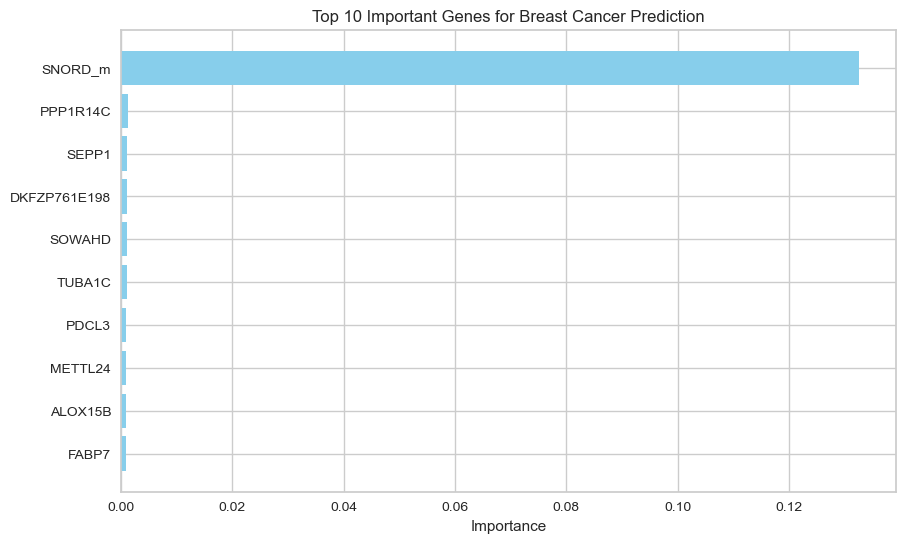

In [149]:
# Plot the top 10 important genes
plt.figure(figsize=(10, 6))
plt.barh(top_genes['Gene'], top_genes['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Important Genes for Breast Cancer Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important gene at the top
plt.show()

In [150]:
genes=[]
for gene in top_genes.Gene:
    genes.append(gene)

print(genes)


['SNORD_m', 'PPP1R14C', 'SEPP1', 'DKFZP761E198', 'SOWAHD', 'TUBA1C', 'PDCL3', 'METTL24', 'ALOX15B', 'FABP7']


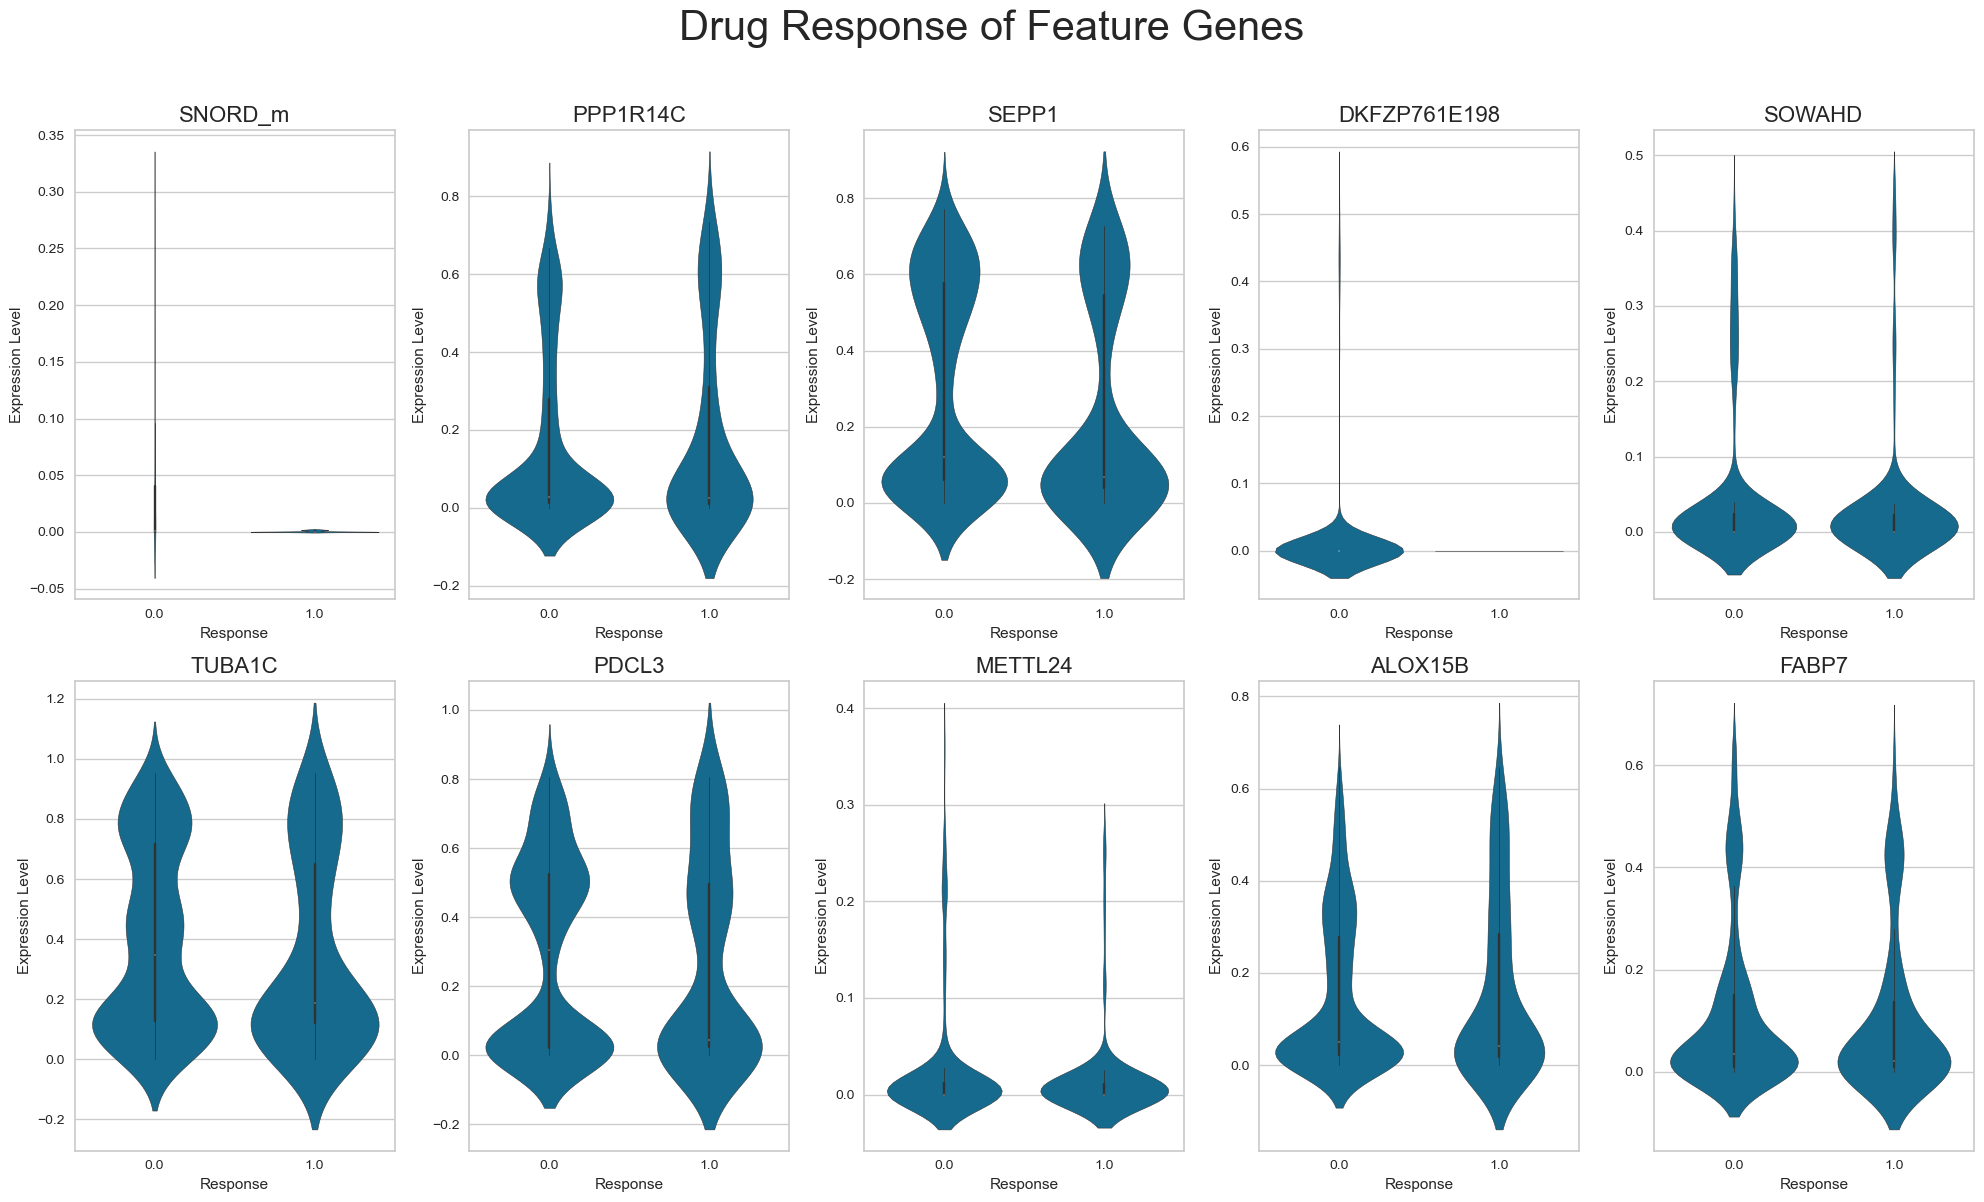

In [154]:
top10_gene=genes
fig, axes = plt.subplots(2, 5, figsize=(20, 12))  # 5 columns, 2 rows
axes = axes.flatten()  # Flatten the axes array to easily iterate over

# Loop through the top10_gene list and plot each gene's expression in a subplot
for i, gene in enumerate(top10_gene):
    sns.violinplot(x=df['Response'], y=df[gene], ax=axes[i])
    axes[i].set_title(f'{gene}', fontsize=16)
    axes[i].set_xlabel('Response')
    axes[i].set_ylabel('Expression Level')

# Set the overall figure title
plt.suptitle('Drug Response of Feature Genes', fontsize=30, y=1.0)  # Adjust 'y' to position the title

# Adjust layout to avoid overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin to fit the title

# Save the figure and display it
plt.savefig('Feature_genes.png', bbox_inches="tight")
plt.show()

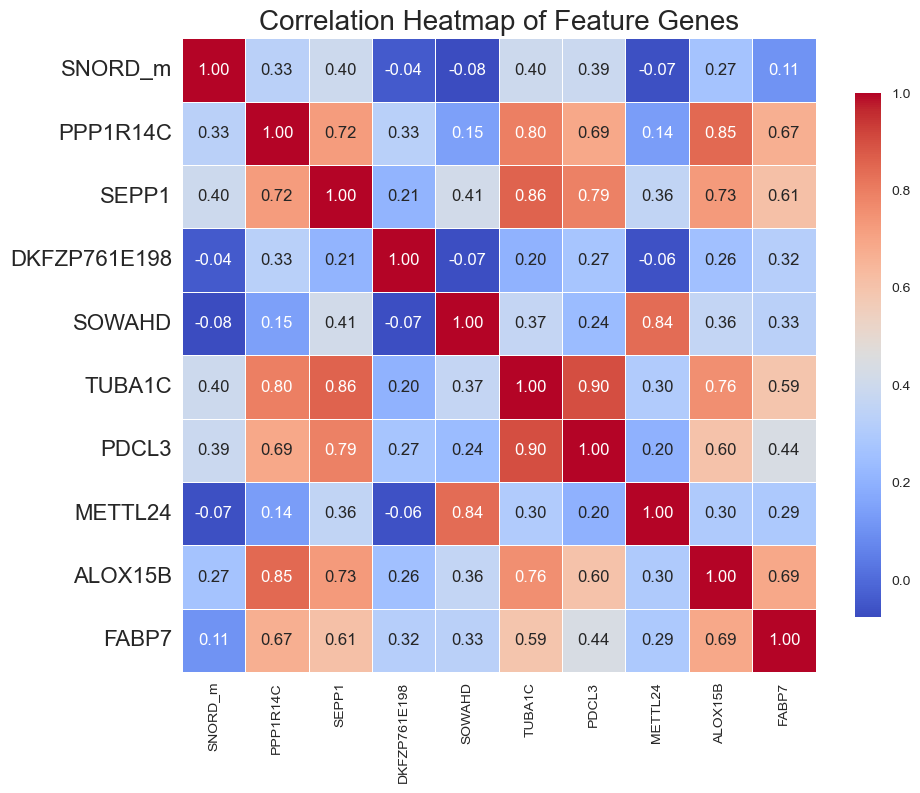

In [155]:
df_genes = df[genes]

# Step 2: Calculate the correlation matrix
correlation_matrix = df_genes.corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(10, 8))  # Set the size of the figure
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", 
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.75})
plt.title('Correlation Heatmap of Feature Genes', fontsize=20, y=1.0)
plt.yticks(fontsize=16)
plt.subplots_adjust(top=1)
plt.tight_layout()
# Save or show the plot
plt.savefig('gene_correlation_heatmap.png', bbox_inches="tight")
plt.show()

/var/folders/ys/kt70q71j7gz446l2lbpzjg9c0000gn/T/ipykernel_41698/2836248182.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=correlation.index, x=correlation.values, palette="coolwarm")


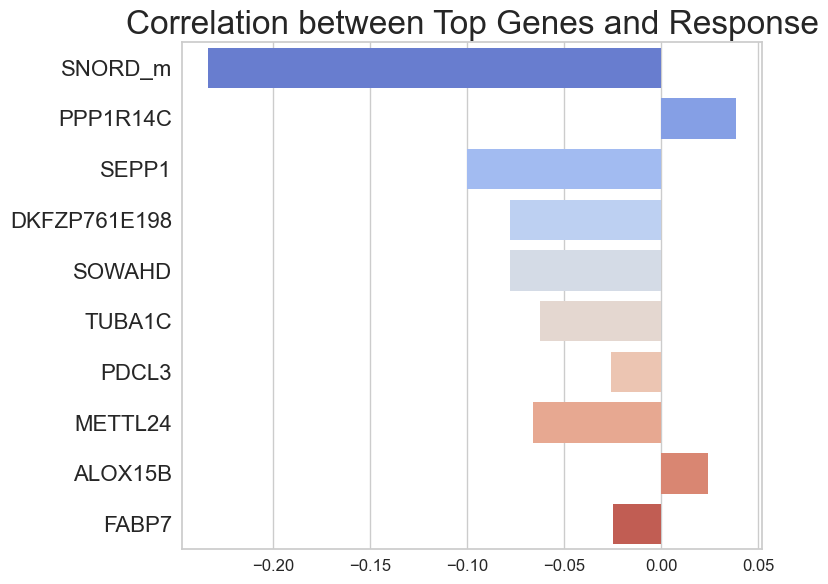

In [161]:
df_genes_response = df[genes + ['Response']]

# Step 2: Calculate the correlation between each gene and the 'Response' column
correlation = df_genes_response.corr()['Response'].drop('Response')  # Exclude 'Response' from the result

# Step 3: Visualize the correlation (optional)
plt.figure(figsize=(8, 6))
sns.barplot(y=correlation.index, x=correlation.values, palette="coolwarm")
plt.title('Correlation between Top Genes and Response', fontsize=24)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=16)
plt.xticks(fontsize=12)
plt.tight_layout()

# Save or show the plot
plt.savefig('gene_response_correlation.png', bbox_inches="tight")
plt.show()

# Print the correlation values
# print(correlation)

In [74]:
import scanpy as sc


## Dimensionality Reduction (PCA)

In [55]:
X = df.drop(columns=['Sample ID','Response'], axis=1)
X.columns = X.columns.astype(str)
scaler = StandardScaler()
decomp = PCA(n_components = 0.9)
pipe = make_pipeline(scaler, decomp)

pipe.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.9))])

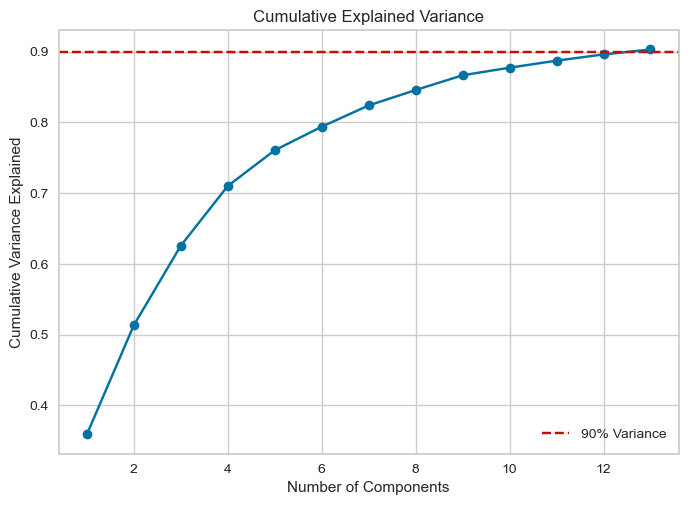

In [57]:

pca = pipe.named_steps['pca']

cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.show()

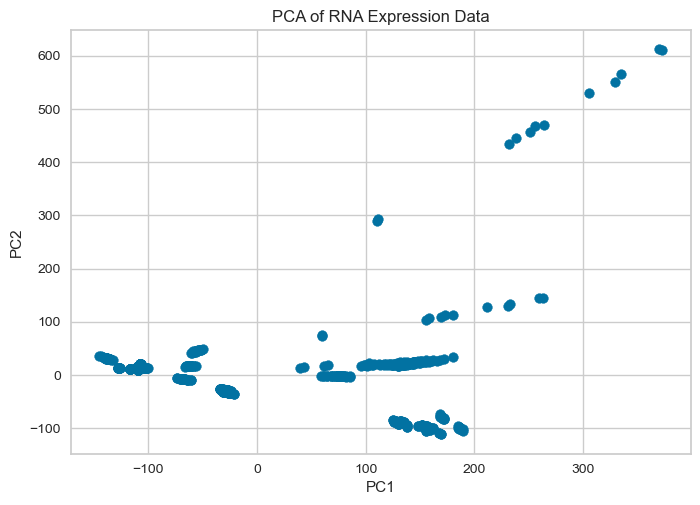

In [58]:
pca_result = pipe.transform(X)

# Now, plot the first two principal components
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA of RNA Expression Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [59]:
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {pca.explained_variance_ratio_.cumsum()}")

Explained variance ratio: [0.35867873 0.15450855 0.11242085 0.0845091  0.05050297 0.03332003
 0.03012965 0.02176497 0.02089081 0.01069435 0.01000256 0.00874954
 0.00704294]
Cumulative explained variance: [0.35867873 0.51318729 0.62560813 0.71011724 0.7606202  0.79394023
 0.82406988 0.84583486 0.86672567 0.87742001 0.88742257 0.89617211
 0.90321505]


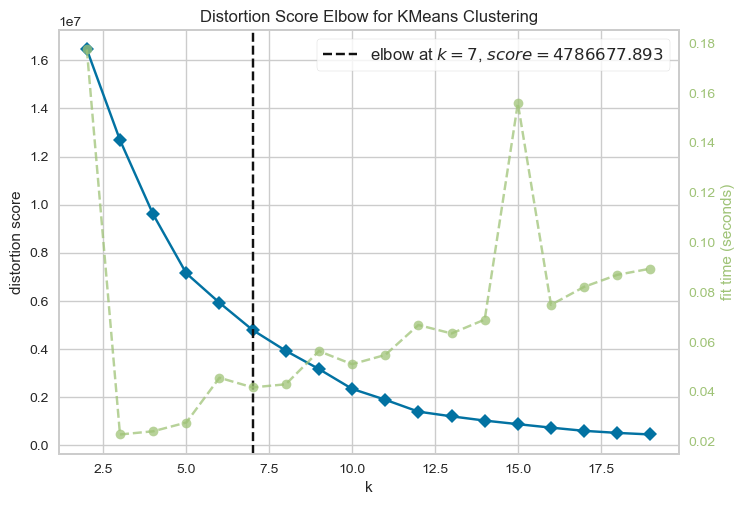

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [60]:
scaler = StandardScaler()
decomp = PCA(n_components=0.9)
cluster = KElbowVisualizer(KMeans(n_init=20),k=(2, 20))  # how many times the model runs, 10 is the default value
pipe = make_pipeline(scaler, decomp, cluster)

pipe.fit(X)
pipe[2].show()

In [61]:
scaler = StandardScaler()
decomp = PCA(n_components=.9)
cluster = KMeans(n_init=10, n_clusters=4)
pipe= make_pipeline(scaler, decomp, cluster)

pipe.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.9)),
                ('kmeans', KMeans(n_clusters=4, n_init=10))])

In [64]:
values = pipe[:2].transform(X)
pca_labels = [f'PC{idx+1}' for idx, i in enumerate(values.T)]
df_pca = df.join(pd.DataFrame(values, columns=pca_labels))

df_pca['clusters'] = pipe['kmeans'].labels_

In [65]:
df_pca.columns

Index(['Sample ID', 'A2M', 'ABCB1', 'ABCF1', 'ABL1', 'ADA', 'ADORA2A', 'AGK',
       'AICDA', 'AIRE',
       ...
       'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13',
       'clusters'],
      dtype='object', length=38073)

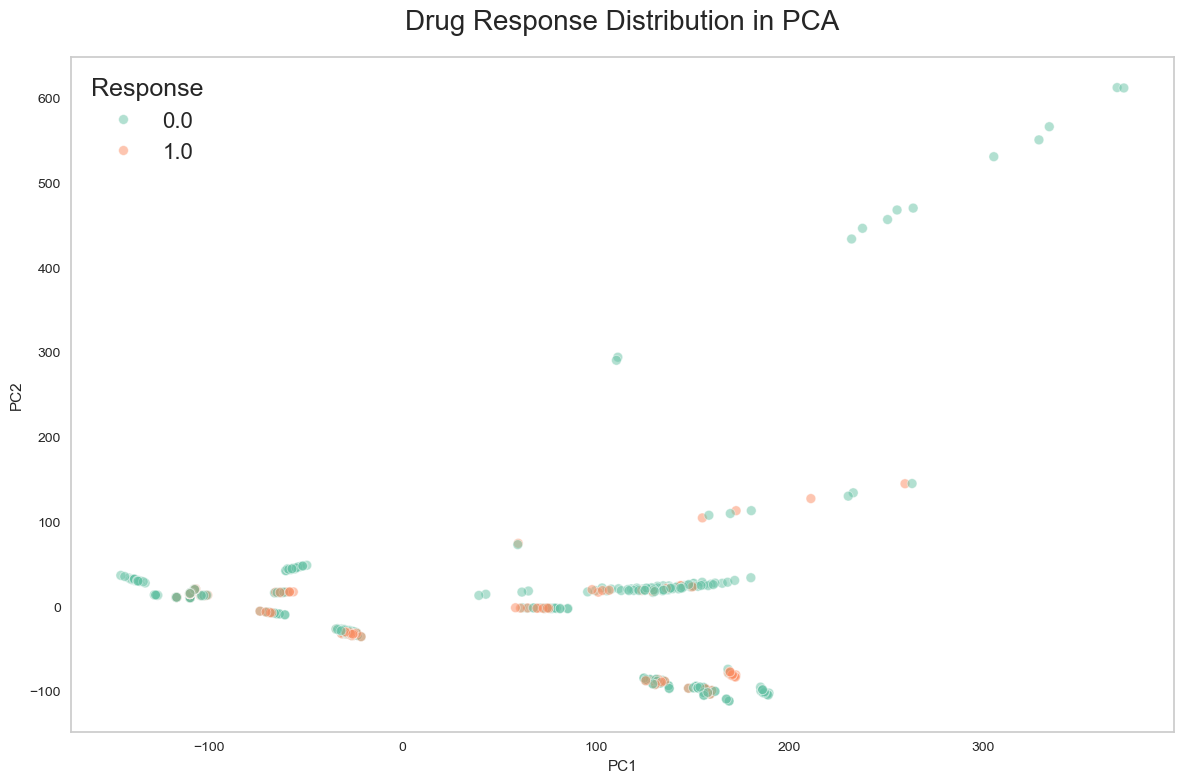

In [119]:
plt.figure(figsize=(12,8))
g = sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Response", alpha=0.5, palette="Set2")
plt.title('Drug Response Distribution in PCA', fontsize=20, pad=20) 
plt.legend(title='Response', fontsize=16, title_fontsize='18')

plt.subplots_adjust(top=0.85)  # Adjust the top margin (default is 0.9)
plt.grid()
plt.tight_layout()

# Save the figure
plt.savefig('Drug_Response_Distribution_PCA.png', bbox_inches="tight")

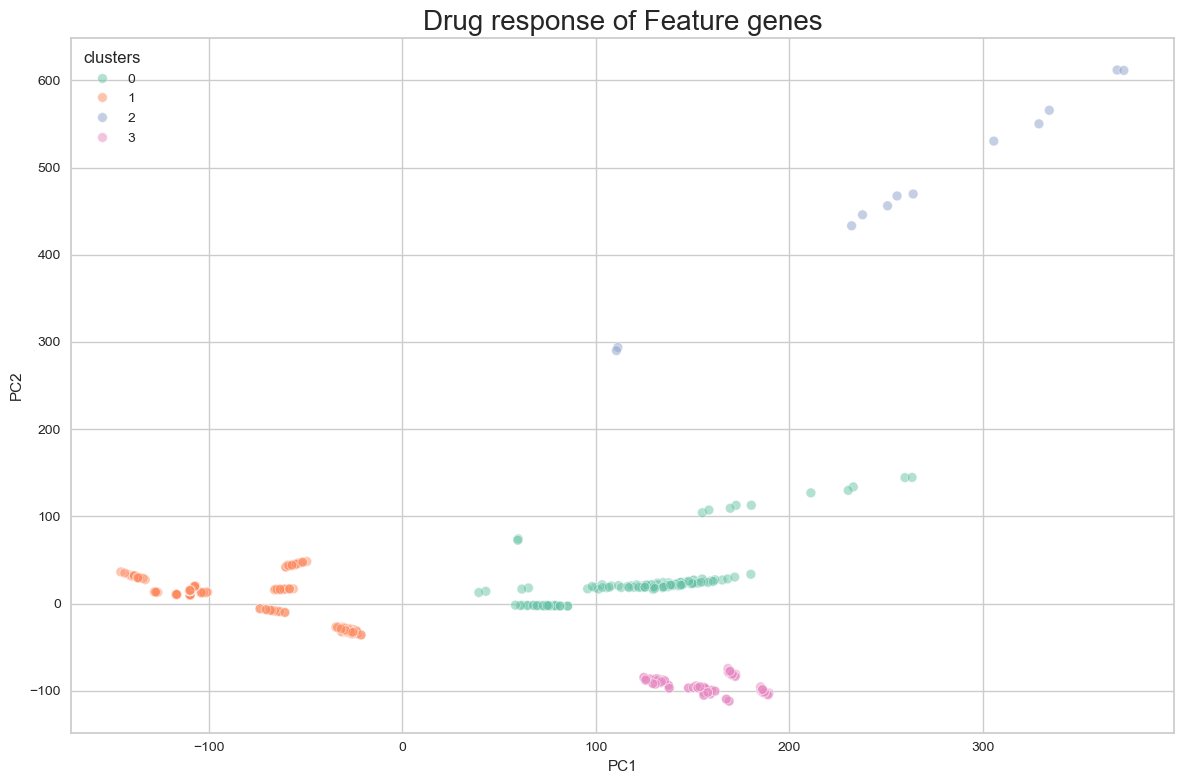

In [93]:
plt.figure(figsize=(12,8))
g = sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="clusters", alpha=0.5, palette="Set2")
plt.title('Drug response of Feature genes', fontsize=20)
plt.tight_layout()

plt.show()

<Axes: xlabel='clusters', ylabel='count'>

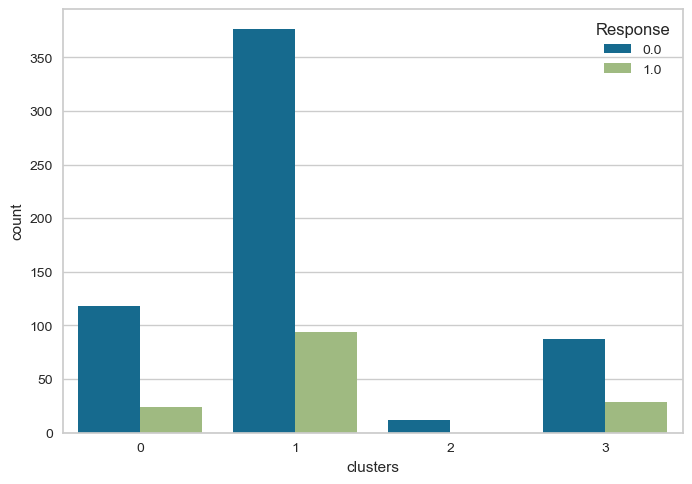

In [94]:
sns.countplot(x = "clusters", hue='Response', data=df_pca)


In [85]:
print(df_pca.dtypes)


Sample ID     object
A2M          float64
ABCB1        float64
ABCF1        float64
ABL1         float64
              ...   
PC10         float64
PC11         float64
PC12         float64
PC13         float64
clusters       int32
Length: 38073, dtype: object


In [86]:
from anndata import AnnData

df_pca_cleaned = df_pca.drop(columns=['Sample ID'])

# Ensure the remaining data is numeric
df_pca_cleaned = df_pca_cleaned.apply(pd.to_numeric, errors='coerce')  # Convert non-numeric to NaN

# Check for any NaN values (optional, depending on how you want to handle them)
print(df_pca_cleaned.isna().sum())

# Handle NaN values (if needed, you can drop or fill NaNs)
df_pca_cleaned = df_pca_cleaned.fillna(df_pca_cleaned.mean())  # Example: Fill NaNs with column mean

# Create the AnnData object with the cleaned data
adata = AnnData(df_pca_cleaned)

A2M         0
ABCB1       0
ABCF1       0
ABL1        0
ADA         0
           ..
PC10        0
PC11        0
PC12        0
PC13        0
clusters    0
Length: 38072, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/anndata/utils.py:307: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [87]:
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata)

# Verify the transformation
print(adata.X.shape)

/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


(740, 38072)


/opt/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:383: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [88]:

sc.pp.neighbors(adata)

# Compute UMAP embeddings
sc.tl.umap(adata)

genes_to_plot = genes

# Determine number of rows and columns for subplots
n_genes = len(genes_to_plot)
n_cols = 3  # Fixed number of columns
n_rows = (n_genes + n_cols - 1) // n_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 6 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot UMAP for each gene with font size adjustments
if genes_to_plot:
    for i, gene in enumerate(genes_to_plot):
        # Use sc.pl.umap to generate plots in the specified axis
        sc.pl.umap(
            adata,
            color=gene,
            color_map="Reds",
            size=20,
            ax=axes[i],   # Specify axis for each plot
            show=False    # Prevent immediate display
        )

        # Adjust font sizes and labels
        axes[i].set_title(f"{gene} Expression", fontsize=16)
        axes[i].tick_params(axis='both', labelsize=12)

        # Remove x and y labels for cleaner look
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

        # Adjust color bar font size
        cbar = axes[i].collections[-1].colorbar
        cbar.ax.tick_params(labelsize=12)

    # Hide any extra empty subplots
    for j in range(len(genes_to_plot), len(axes)):
        fig.delaxes(axes[j])

    # Optimize layout and spacing
    plt.tight_layout()

    # Save the figure
    plt.savefig("UMAP_of_Gene_Expression.png",
                transparent=True, bbox_inches="tight")
else:
    print("None of the selected genes are found in the dataset.")

/opt/anaconda3/lib/python3.12/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 38072 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# 3. Machine learning model to predict drug response

In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import StandardScaler, OneHotEncoder  
from sklearn.compose import make_column_transformer  
from sklearn.pipeline import make_pipeline  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## ML with PCA 

In [95]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)
y = df['Response']  

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

### Baseline

In [99]:
# Baseline: Predict the most frequent class (for classification)
baseline_pred = y.mode()[0]  # Most frequent class

# Evaluate the baseline model using Accuracy
accuracy_baseline = accuracy_score(y, [baseline_pred] * len(y))
print(f"Baseline Accuracy (Most Frequent Class): {accuracy_baseline}")

Baseline Accuracy (Most Frequent Class): 0.8013513513513514


In [96]:
classifier_scale = [SVC(),
                     KNeighborsClassifier(),
                     GradientBoostingClassifier(n_estimators=100, random_state=42)]

classifier_not_scale = [LogisticRegression(),
                         DecisionTreeClassifier(),
                         RandomForestClassifier()]
    
scaler = StandardScaler()

In [97]:
for classifier in classifier_scale:
    pipe = make_pipeline(StandardScaler(), classifier)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
    
    # Evaluate the model
    accuracy = accuracy_score(y_train, y_pred)
    print(f'{classifier} Accuracy: {accuracy * 100:.2f}%')
    print("Classification Report:")
    print(classification_report(y_train, y_pred))

# Evaluate regressors that do not require scaling
for classifier in classifier_not_scale:
    pipe = make_pipeline(classifier)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
     # Evaluate the model
    accuracy = accuracy_score(y_train, y_pred)
    print(f'{classifier} Accuracy: {accuracy * 100:.2f}%')
    print("Classification Report:")
    print(classification_report(y_train, y_pred))

SVC() Accuracy: 81.42%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.89       469
         1.0       0.76      0.15      0.26       123

    accuracy                           0.81       592
   macro avg       0.79      0.57      0.58       592
weighted avg       0.80      0.81      0.76       592

KNeighborsClassifier() Accuracy: 82.77%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90       469
         1.0       0.63      0.41      0.50       123

    accuracy                           0.83       592
   macro avg       0.75      0.67      0.70       592
weighted avg       0.81      0.83      0.81       592

GradientBoostingClassifier(random_state=42) Accuracy: 92.06%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       469
         1.0       0.99      0.63      0.77 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier() Accuracy: 99.66%
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       469
         1.0       0.98      1.00      0.99       123

    accuracy                           1.00       592
   macro avg       0.99      1.00      0.99       592
weighted avg       1.00      1.00      1.00       592



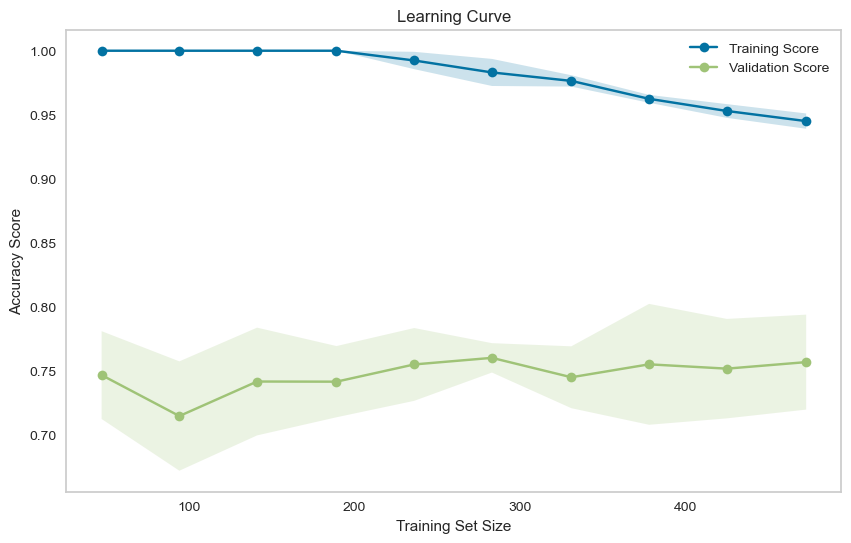

In [98]:
pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=100, random_state=42))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    pipe, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label="Validation Score", marker='o')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

In [101]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'algorithm': ['auto', 'kd_tree'],
    'p': [1, 2],
    'metric': ['minkowski', 'manhattan']
}

# Instantiate the model
knn = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, error_score='raise')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2}
Best cross-validation score: 0.7990314769975788


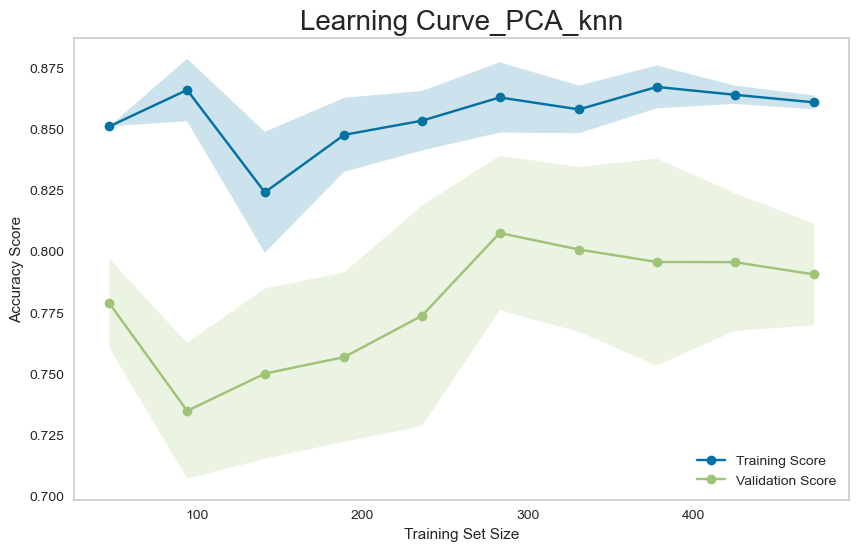

In [109]:
best_params = {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5, 'p': 2}
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(**best_params))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    pipe, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label="Validation Score", marker='o')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve_PCA_knn", fontsize=20)
plt.legend()
plt.grid()
plt.savefig('learning_score')
plt.show()

## ML with original X

In [104]:
X = df.drop(columns=['Sample ID','Response'], axis=1)
y = df['Response']  

X.columns = X.columns.astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [105]:
classifier_scale = [SVC(),
                     KNeighborsClassifier(),
                     GradientBoostingClassifier(n_estimators=100, random_state=42)]

classifier_not_scale = [LogisticRegression(),
                         DecisionTreeClassifier(),
                         RandomForestClassifier()]
    
scaler = StandardScaler()

In [106]:
for classifier in classifier_scale:
    pipe = make_pipeline(StandardScaler(), classifier)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
    
    # Evaluate the model
    accuracy = accuracy_score(y_train, y_pred)
    print(f'{classifier} Accuracy: {accuracy * 100:.2f}%')
    print("Classification Report:")
    print(classification_report(y_train, y_pred))

# Evaluate regressors that do not require scaling
for classifier in classifier_not_scale:
    pipe = make_pipeline(classifier)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_train)
     # Evaluate the model
    accuracy = accuracy_score(y_train, y_pred)
    print(f'{classifier} Accuracy: {accuracy * 100:.2f}%')
    print("Classification Report:")
    print(classification_report(y_train, y_pred))
 
  

SVC() Accuracy: 81.42%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.89       469
         1.0       0.76      0.15      0.26       123

    accuracy                           0.81       592
   macro avg       0.79      0.57      0.58       592
weighted avg       0.80      0.81      0.76       592

KNeighborsClassifier() Accuracy: 85.81%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91       469
         1.0       0.73      0.50      0.60       123

    accuracy                           0.86       592
   macro avg       0.80      0.73      0.76       592
weighted avg       0.85      0.86      0.85       592

GradientBoostingClassifier(random_state=42) Accuracy: 99.66%
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       469
         1.0       1.00      0.98      0.99 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() Accuracy: 88.18%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       469
         1.0       0.88      0.50      0.64       123

    accuracy                           0.88       592
   macro avg       0.88      0.74      0.78       592
weighted avg       0.88      0.88      0.87       592

DecisionTreeClassifier() Accuracy: 99.66%
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       469
         1.0       1.00      0.98      0.99       123

    accuracy                           1.00       592
   macro avg       1.00      0.99      0.99       592
weighted avg       1.00      1.00      1.00       592

RandomForestClassifier() Accuracy: 99.66%
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       469
         1.0       1.00      0.98      0.99   

##  3.2 Trianing and Evaluation of Model Performance

### KNeighborsClassifier

In [107]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'algorithm': ['auto', 'kd_tree'],
    'p': [1, 2],
    'metric': ['minkowski', 'manhattan']
}

# Instantiate the model
knn = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, error_score='raise')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 9, 'p': 2}
Best cross-validation score: 0.7990599629682382


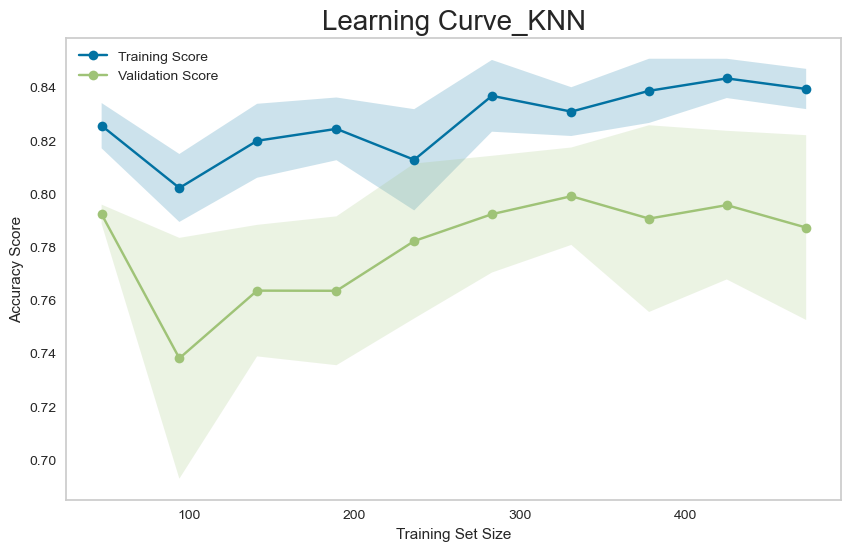

In [112]:


best_params = {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 9, 'p': 2}
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(**best_params))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)

from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    pipe, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label="Validation Score", marker='o')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve")
plt.legend()
plt.title("Learning Curve_KNN", fontsize=20)
plt.grid()
plt.savefig('learning_score_knn.png', bbox_inches="tight")
plt.show()

In [163]:
best_params = {'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 9, 'p': 2}
pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(**best_params))
pipe.fit(X_test, y_test)
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'{classifier} Accuracy: {accuracy * 100:.2f}%')
print("Classification Report:")
print(classification_report(y_test, y_pred))

RandomForestClassifier() Accuracy: 84.46%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91       124
         1.0       0.56      0.21      0.30        24

    accuracy                           0.84       148
   macro avg       0.71      0.59      0.61       148
weighted avg       0.81      0.84      0.81       148

